Dispositivo utilizado: cpu
Dimensiones de los datasets:
Train: (3680, 20)
Test: (520, 19)
Sample submission: (520, 2)

Información general del dataset de entrenamiento:
<class 'pandas.core.frame.DataFrame'>
Index: 3680 entries, 9 to 3674
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                3680 non-null   object        
 1   id_bar            3680 non-null   int64         
 2   anio              3680 non-null   int64         
 3   semana            3680 non-null   UInt32        
 4   ESTRATO           3680 non-null   float64       
 5   area_barrio       3680 non-null   float64       
 6   dengue            3680 non-null   float64       
 7   concentraciones   3680 non-null   float64       
 8   vivienda          3680 non-null   float64       
 9   equipesado        3680 non-null   float64       
 10  sumideros         3680 non-null   float64       
 11  maquina           3680

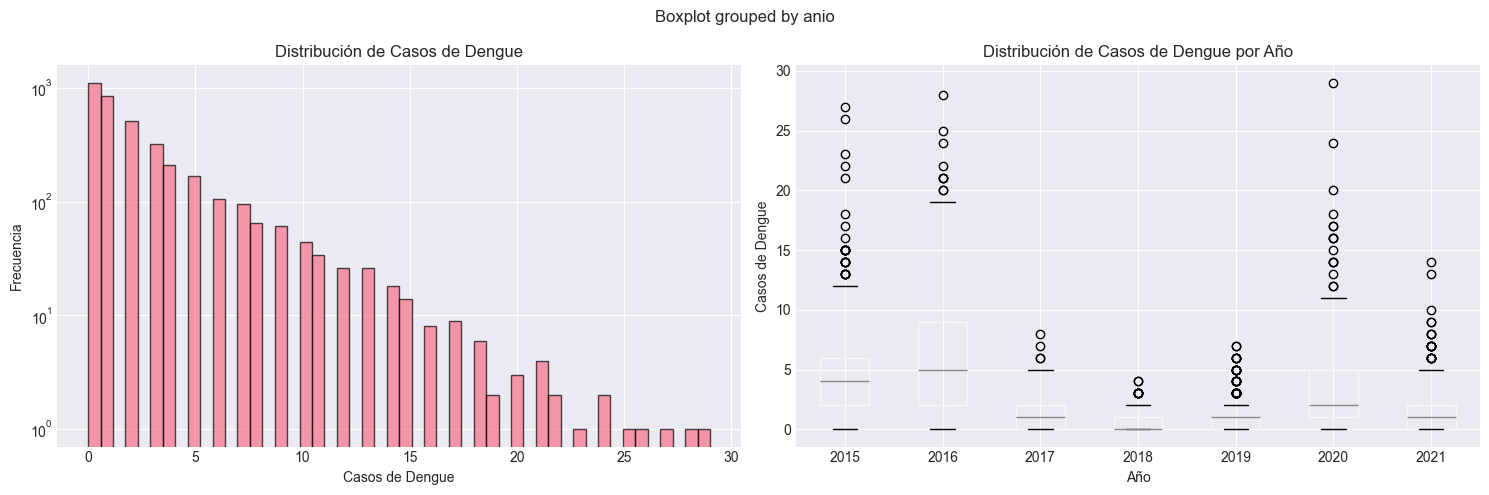

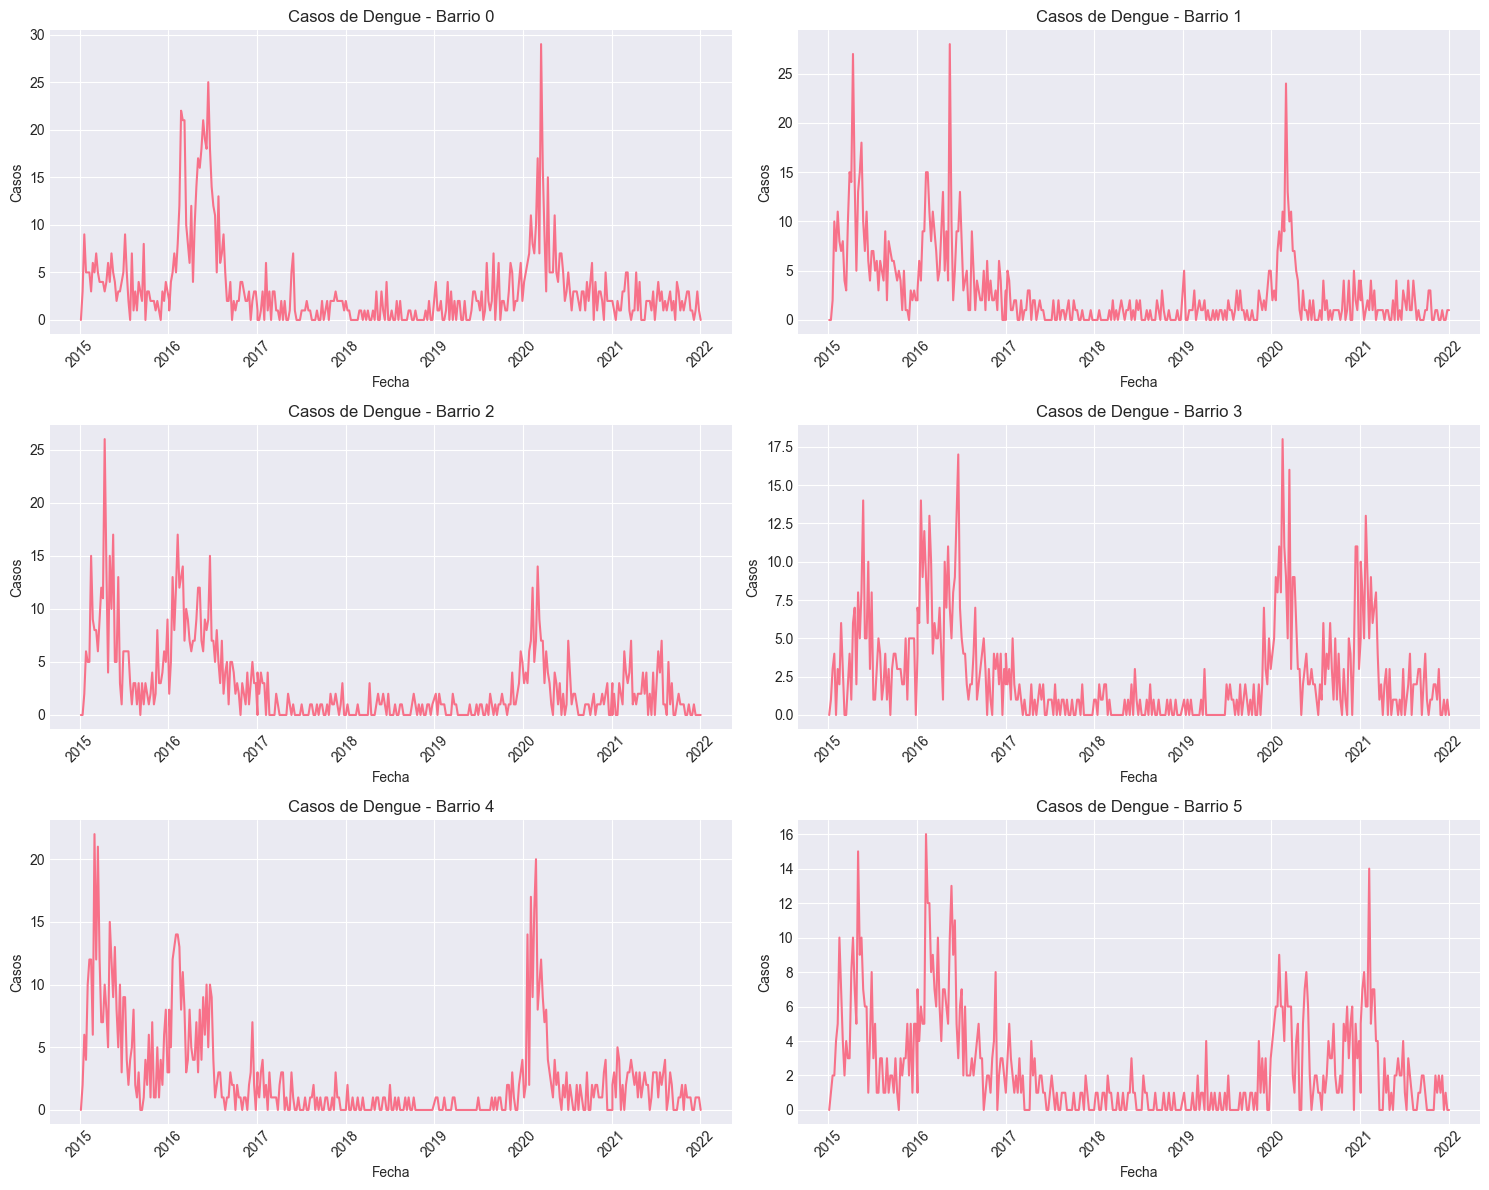

ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
# Pipeline de Pronóstico de Dengue usando LSTM con PyTorch

## 0. Configuración Inicial


# Importación de librerías esenciales
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.trial import TrialState
import warnings
import os
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
import gc

warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configuraciones globales
RANDOM_SEED = 42
DATA_PATH = "../../Datos"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo utilizado: {DEVICE}")

# Establecer semillas para reproducibilidad
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True


## 1. Análisis Exploratorio de Datos (EDA) Orientado a Series de Tiempo

### 1.1 Carga de Datos


# Cargar los datos
df_train = pd.read_parquet(os.path.join(DATA_PATH, 'df_train.parquet')).reset_index(drop=True)
df_test = pd.read_parquet(os.path.join(DATA_PATH, 'df_test.parquet')).reset_index(drop=True)
sample_submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv')).reset_index(drop=True)

print("Dimensiones de los datasets:")
print(f"Train: {df_train.shape}")
print(f"Test: {df_test.shape}")
print(f"Sample submission: {sample_submission.shape}")

# Crear columna de fecha para facilitar el análisis temporal
def create_date_column(df):
    """Crea una columna de fecha a partir del año y semana."""
    df['date'] = df.apply(
        lambda row: datetime.strptime(f"{int(row['anio'])}-W{int(row['semana'])}-1", "%Y-W%W-%w"), 
        axis=1
    )
    return df

df_train = create_date_column(df_train)
df_test = create_date_column(df_test)

# Ordenar por barrio y fecha
df_train = df_train.sort_values(['id_bar', 'date'])
df_test = df_test.sort_values(['id_bar', 'date'])

print("\nInformación general del dataset de entrenamiento:")
df_train.info()


### 1.2 Análisis de la Variable Objetivo


# Estadísticas descriptivas de la variable objetivo
print("Estadísticas de casos de dengue:")
print(df_train['dengue'].describe())

# Distribución de casos de dengue
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograma
axes[0].hist(df_train['dengue'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Casos de Dengue')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Casos de Dengue')
axes[0].set_yscale('log')

# Boxplot por año
df_train.boxplot(column='dengue', by='anio', ax=axes[1])
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Casos de Dengue')
axes[1].set_title('Distribución de Casos de Dengue por Año')

plt.tight_layout()
plt.show()


### 1.3 Visualización de Series de Tiempo


# Seleccionar una muestra de barrios para visualización
barrios_muestra = df_train['id_bar'].unique()[:6]

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, barrio in enumerate(barrios_muestra):
    data_barrio = df_train[df_train['id_bar'] == barrio]
    axes[idx].plot(data_barrio['date'], data_barrio['dengue'], linewidth=1.5)
    axes[idx].set_title(f'Casos de Dengue - Barrio {barrio}')
    axes[idx].set_xlabel('Fecha')
    axes[idx].set_ylabel('Casos')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### 1.4 Análisis de Descomposición Estacional


# Descomposición estacional para un barrio representativo
barrio_ejemplo = df_train['id_bar'].value_counts().index[0]  # Barrio con más datos
data_barrio = df_train[df_train['id_bar'] == barrio_ejemplo].set_index('date')['dengue']

# Eliminar fechas duplicadas antes de reindexar
data_barrio = data_barrio[~data_barrio.index.duplicated(keep='first')]
# Asegurar frecuencia semanal
data_barrio = data_barrio.asfreq('W', method='ffill')

# Realizar descomposición
decomposition = seasonal_decompose(data_barrio, model='additive', period=52)

fig, axes = plt.subplots(4, 1, figsize=(15, 12))

data_barrio.plot(ax=axes[0], title=f'Serie Original - Barrio {barrio_ejemplo}')
decomposition.trend.plot(ax=axes[1], title='Tendencia')
decomposition.seasonal.plot(ax=axes[2], title='Estacionalidad')
decomposition.resid.plot(ax=axes[3], title='Residuos')

plt.tight_layout()
plt.show()


### 1.5 Análisis de Variables Exógenas


# Seleccionar variables numéricas para análisis
variables_numericas = ['dengue', 'ESTRATO', 'area_barrio', 'concentraciones', 
                      'vivienda', 'equipesado', 'sumideros', 'maquina',
                      'lluvia_mean', 'lluvia_var', 'lluvia_max', 'lluvia_min',
                      'temperatura_mean', 'temperatura_var', 'temperatura_max', 'temperatura_min']

# Matriz de correlación
correlation_matrix = df_train[variables_numericas].corr()

plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title('Matriz de Correlación de Variables')
plt.tight_layout()
plt.show()

# Correlación específica con dengue
dengue_corr = correlation_matrix['dengue'].sort_values(ascending=False)
print("Correlación de variables con casos de dengue:")
print(dengue_corr)


## 2. Ingeniería y Selección de Características

### 2.1 Selección de Variables


# Basado en el análisis de correlación y conocimiento del dominio,
# seleccionamos las siguientes variables
FEATURE_COLUMNS = [
    'ESTRATO', 'area_barrio', 'concentraciones', 'vivienda', 
    'equipesado', 'sumideros', 'maquina',
    'lluvia_mean', 'lluvia_var', 'lluvia_max', 'lluvia_min',
    'temperatura_mean', 'temperatura_var', 'temperatura_max', 'temperatura_min'
]

print(f"Variables seleccionadas: {len(FEATURE_COLUMNS)}")
print("Justificación:")
print("- Variables socioeconómicas (ESTRATO, vivienda): Impactan en condiciones sanitarias")
print("- Variables climáticas (lluvia, temperatura): Afectan reproducción del mosquito")
print("- Variables de infraestructura (sumideros, equipesado): Relacionadas con acumulación de agua")


### 2.2 Gestión de Valores Faltantes


# Verificar valores faltantes
print("Valores faltantes en train:")
print(df_train[FEATURE_COLUMNS + ['dengue']].isnull().sum())

# Si hay valores faltantes, usar interpolación para series de tiempo
for col in FEATURE_COLUMNS + ['dengue']:
    if df_train[col].isnull().any():
        df_train[col] = df_train.groupby('id_bar')[col].transform(
            lambda x: x.interpolate(method='linear', limit_direction='both')
        )

print("\nValores faltantes después de interpolación:")
print(df_train[FEATURE_COLUMNS + ['dengue']].isnull().sum())


### 2.3 Preparación de id_bar como Variable Categórica


# Crear mapeo de id_bar a índices
# Incluir barrios de ambos conjuntos (train y test)
all_bars = sorted(set(df_train['id_bar'].unique()) | set(df_test['id_bar'].unique()))
bar_to_idx = {bar: idx for idx, bar in enumerate(all_bars)}
idx_to_bar = {idx: bar for bar, idx in bar_to_idx.items()}

# Aplicar mapeo
df_train['id_bar_idx'] = df_train['id_bar'].map(bar_to_idx)
df_test['id_bar_idx'] = df_test['id_bar'].map(bar_to_idx)

print(f"Número total de barrios: {len(all_bars)}")
print(f"Barrios en train: {len(df_train['id_bar'].unique())}")
print(f"Barrios en test: {len(df_test['id_bar'].unique())}")
print(f"Barrios solo en test: {len(set(df_test['id_bar'].unique()) - set(df_train['id_bar'].unique()))}")

# Variable global para el número de barrios únicos
unique_bars = all_bars


## 3. Creación de Datasets y DataLoaders de PyTorch

### 3.1 Función para Crear Secuencias


def create_sequences(data, sequence_length, forecast_horizon=1):
    """
    Crea secuencias de entrada-salida para el modelo LSTM.
    
    Args:
        data: DataFrame con los datos ordenados por barrio y fecha
        sequence_length: Longitud de la secuencia de entrada
        forecast_horizon: Número de pasos a predecir (default=1)
    
    Returns:
        sequences: Lista de tuplas (X, y, id_bar_idx)
    """
    sequences = []
    
    for id_bar in data['id_bar'].unique():
        bar_data = data[data['id_bar'] == id_bar].sort_values('date')
        
        if len(bar_data) < sequence_length + forecast_horizon:
            continue
            
        features = bar_data[FEATURE_COLUMNS].values
        target = bar_data['dengue'].values
        id_bar_idx = bar_data['id_bar_idx'].iloc[0]
        
        for i in range(len(bar_data) - sequence_length - forecast_horizon + 1):
            X = features[i:i + sequence_length]
            y = target[i + sequence_length:i + sequence_length + forecast_horizon]
            sequences.append((X, y, id_bar_idx))
    
    return sequences


### 3.2 Dataset Personalizado


class DengueDataset(Dataset):
    """Dataset personalizado para series de tiempo de dengue."""
    
    def __init__(self, sequences, scaler=None, fit_scaler=False):
        self.sequences = sequences
        self.scaler = scaler
        
        # Extraer todas las características para normalización
        if fit_scaler and self.scaler is not None:
            all_features = []
            for X, _, _ in sequences:
                all_features.extend(X)
            all_features = np.array(all_features)
            self.scaler.fit(all_features)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        X, y, id_bar_idx = self.sequences[idx]
        
        # Normalizar características
        if self.scaler is not None:
            X = self.scaler.transform(X)
        
        # Convertir a tensores
        X = torch.FloatTensor(X)
        y = torch.FloatTensor(y)
        id_bar_idx = torch.LongTensor([id_bar_idx])
        
        return X, y, id_bar_idx


### 3.3 Preparación de Datos para Entrenamiento


# Dividir datos en entrenamiento y validación
# Usamos los últimos 6 meses de cada barrio para validación
train_data = []
val_data = []

for id_bar in df_train['id_bar'].unique():
    bar_data = df_train[df_train['id_bar'] == id_bar].sort_values('date')
    split_idx = int(len(bar_data) * 0.85)  # 85% para entrenamiento
    
    train_data.append(bar_data.iloc[:split_idx])
    val_data.append(bar_data.iloc[split_idx:])

train_df = pd.concat(train_data)
val_df = pd.concat(val_data)

print(f"Tamaño conjunto entrenamiento: {len(train_df)}")
print(f"Tamaño conjunto validación: {len(val_df)}")

# Crear escalador
scaler = StandardScaler()

# Esta función se usará para crear dataloaders con diferentes hiperparámetros
def create_dataloaders(sequence_length, batch_size):
    """Crea dataloaders con los hiperparámetros especificados."""
    # Crear secuencias
    train_sequences = create_sequences(train_df, sequence_length)
    val_sequences = create_sequences(val_df, sequence_length)
    
    # Crear datasets
    train_dataset = DengueDataset(train_sequences, scaler=scaler, fit_scaler=True)
    val_dataset = DengueDataset(val_sequences, scaler=scaler, fit_scaler=False)
    
    # Crear dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader


## 4. Arquitectura de la Red Neuronal (LSTM)


class DengueLSTM(nn.Module):
    """
    Arquitectura LSTM para pronóstico de dengue.
    Incluye embeddings para el id_bar y capas de regularización.
    """
    
    def __init__(self, input_size, hidden_size, num_layers, output_size, 
                 num_barrios, embedding_dim=16, dropout_rate=0.2):
        super(DengueLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Embedding para id_bar
        self.barrio_embedding = nn.Embedding(num_barrios, embedding_dim)
        
        # LSTM con dropout entre capas
        self.lstm = nn.LSTM(
            input_size + embedding_dim,  # Incluye embedding
            hidden_size, 
            num_layers, 
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0
        )
        
        # Batch normalization
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
        
        # Capas fully connected
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        
        # Activación
        self.relu = nn.ReLU()
        
    def forward(self, x, id_bar_idx):
        batch_size = x.size(0)
        seq_length = x.size(1)
        
        # Obtener embeddings de barrio
        barrio_emb = self.barrio_embedding(id_bar_idx)  # (batch_size, 1, embedding_dim)
        barrio_emb = barrio_emb.expand(batch_size, seq_length, -1)  # Expandir para todas las timesteps
        
        # Concatenar características con embeddings
        x = torch.cat([x, barrio_emb], dim=-1)
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(x)
        
        # Tomar la última salida
        last_output = lstm_out[:, -1, :]
        
        # Batch normalization
        normalized = self.batch_norm(last_output)
        
        # Dropout
        dropped = self.dropout(normalized)
        
        # Capas fully connected
        out = self.relu(self.fc1(dropped))
        out = self.fc2(out)
        
        # ReLU final para asegurar predicciones no negativas
        out = torch.relu(out)
        
        return out


## 5. Búsqueda de Hiperparámetros con Optuna


def train_epoch(model, train_loader, optimizer, criterion, device):
    """Entrena el modelo por una época."""
    model.train()
    total_loss = 0
    
    for X, y, id_bar_idx in train_loader:
        X, y, id_bar_idx = X.to(device), y.to(device), id_bar_idx.squeeze().to(device)
        
        optimizer.zero_grad()
        outputs = model(X, id_bar_idx)
        loss = criterion(outputs.squeeze(), y.squeeze())
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def validate(model, val_loader, criterion, device):
    """Valida el modelo."""
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for X, y, id_bar_idx in val_loader:
            X, y, id_bar_idx = X.to(device), y.to(device), id_bar_idx.squeeze().to(device)
            
            outputs = model(X, id_bar_idx)
            loss = criterion(outputs.squeeze(), y.squeeze())
            
            total_loss += loss.item()
            all_predictions.extend(outputs.squeeze().cpu().numpy())
            all_targets.extend(y.squeeze().cpu().numpy())
    
    mae = np.mean(np.abs(np.array(all_predictions) - np.array(all_targets)))
    return total_loss / len(val_loader), mae

def objective(trial):
    """Función objetivo para Optuna."""
    # Hiperparámetros a optimizar
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    sequence_length = trial.suggest_int('sequence_length', 8, 52)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    hidden_size = trial.suggest_categorical('hidden_size', [32, 64, 128, 256])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
    # Crear dataloaders
    train_loader, val_loader = create_dataloaders(sequence_length, batch_size)
    
    # Crear modelo
    model = DengueLSTM(
        input_size=len(FEATURE_COLUMNS),
        hidden_size=hidden_size,
        num_layers=num_layers,
        output_size=1,
        num_barrios=len(all_bars),  # Usar todos los barrios (train + test)
        dropout_rate=dropout_rate
    ).to(DEVICE)
    
    # Optimizador y función de pérdida
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    # Early stopping
    best_val_mae = float('inf')
    patience = 10
    patience_counter = 0
    
    # Entrenamiento
    for epoch in range(50):  # Máximo 50 épocas
        train_loss = train_epoch(model, train_loader, optimizer, criterion, DEVICE)
        val_loss, val_mae = validate(model, val_loader, criterion, DEVICE)
        
        # Early stopping
        if val_mae < best_val_mae:
            best_val_mae = val_mae
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            break
            
        # Pruning de Optuna
        trial.report(val_mae, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return best_val_mae

# Ejecutar búsqueda de hiperparámetros
print("Iniciando búsqueda de hiperparámetros con Optuna...")
study = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)
)

study.optimize(objective, n_trials=30, show_progress_bar=True)

print("\nMejores hiperparámetros encontrados:")
print(study.best_params)
print(f"Mejor MAE en validación: {study.best_value:.4f}")

# Visualizar importancia de hiperparámetros
optuna.visualization.plot_param_importances(study).show()


## 6. Entrenamiento del Modelo Final


# Usar los mejores hiperparámetros
best_params = study.best_params
print("Entrenando modelo final con mejores hiperparámetros...")

# Crear dataloaders con todos los datos de entrenamiento
all_train_sequences = create_sequences(df_train, best_params['sequence_length'])
final_train_dataset = DengueDataset(all_train_sequences, scaler=scaler, fit_scaler=True)
final_train_loader = DataLoader(
    final_train_dataset, 
    batch_size=best_params['batch_size'], 
    shuffle=True,
    drop_last=True
)

# Crear modelo final
final_model = DengueLSTM(
    input_size=len(FEATURE_COLUMNS),
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    output_size=1,
    num_barrios=len(all_bars),  # Usar todos los barrios (train + test)
    dropout_rate=best_params['dropout_rate']
).to(DEVICE)

# Entrenamiento final
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])
criterion = nn.MSELoss()

train_losses = []
num_epochs = 100

for epoch in range(num_epochs):
    train_loss = train_epoch(final_model, final_train_loader, optimizer, criterion, DEVICE)
    train_losses.append(train_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Época {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}")

# Guardar el modelo
torch.save({
    'model_state_dict': final_model.state_dict(),
    'scaler': scaler,
    'best_params': best_params,
    'feature_columns': FEATURE_COLUMNS,
    'bar_to_idx': bar_to_idx
}, 'dengue_lstm_model.pth')

print("Modelo guardado exitosamente.")

# Visualizar curva de entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.title('Curva de Pérdida de Entrenamiento')
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()


## 7. Generación de Pronósticos para 2022


def generate_recursive_predictions(model, initial_data, num_weeks, id_bar_idx, device):
    """
    Genera predicciones recursivas para múltiples semanas.
    """
    model.eval()
    predictions = []
    
    # Preparar datos iniciales
    current_sequence = initial_data.copy()
    
    with torch.no_grad():
        for week in range(num_weeks):
            # Convertir a tensor
            X = torch.FloatTensor(current_sequence).unsqueeze(0).to(device)
            id_bar_tensor = torch.LongTensor([id_bar_idx]).to(device)
            
            # Predecir
            prediction = model(X, id_bar_tensor).squeeze().cpu().numpy()
            predictions.append(prediction)
            
            # Actualizar secuencia: remover primera fila y agregar predicción
            # Para las características, usamos la última fila conocida
            # (asumiendo que las condiciones climáticas se mantienen similares)
            new_row = current_sequence[-1].copy()
            current_sequence = np.vstack([current_sequence[1:], new_row])
    
    return predictions

# Preparar datos para predicción
print("Generando predicciones para 2022...")

# Obtener las últimas secuencias de cada barrio de 2021
last_sequences = {}
barrios_sin_datos = []

for id_bar in all_bars:
    bar_data = df_train[df_train['id_bar'] == id_bar].sort_values('date')
    if len(bar_data) >= best_params['sequence_length']:
        last_features = bar_data[FEATURE_COLUMNS].values[-best_params['sequence_length']:]
        last_sequences[id_bar] = scaler.transform(last_features)
    else:
        barrios_sin_datos.append(id_bar)

print(f"Barrios con datos suficientes: {len(last_sequences)}")
print(f"Barrios sin datos suficientes: {len(barrios_sin_datos)}")

# Generar predicciones para cada barrio
all_predictions = []
barrios_procesados = 0

for id_bar in df_test['id_bar'].unique():
    # Obtener datos del barrio para 2022
    test_data = df_test[df_test['id_bar'] == id_bar].sort_values('date')
    
    if id_bar not in last_sequences:
        # Para barrios sin datos históricos suficientes, usar predicción promedio
        print(f"Advertencia: Barrio {id_bar} sin datos suficientes. Usando predicción promedio.")
        
        # Calcular promedio de dengue para este estrato si está disponible
        if 'ESTRATO' in df_test.columns:
            estrato = df_test[df_test['id_bar'] == id_bar]['ESTRATO'].iloc[0]
            promedio_estrato = df_train[df_train['ESTRATO'] == estrato]['dengue'].mean()
        else:
            promedio_estrato = df_train['dengue'].mean()
        
        # Agregar predicciones promedio
        for _, row in test_data.iterrows():
            all_predictions.append({
                'id': f"{int(row['id_bar'])}_{int(row['anio'])}_{int(row['semana'])}",
                'dengue': max(0, promedio_estrato)
            })
    else:
        # Generar predicciones recursivas
        try:
            predictions = generate_recursive_predictions(
                final_model,
                last_sequences[id_bar],
                len(test_data),
                bar_to_idx.get(id_bar, 0),  # Usar 0 como default si no existe
                DEVICE
            )
            
            # Crear DataFrame con predicciones
            for idx, (_, row) in enumerate(test_data.iterrows()):
                all_predictions.append({
                    'id': f"{int(row['id_bar'])}_{int(row['anio'])}_{int(row['semana'])}",
                    'dengue': max(0, predictions[idx])  # Asegurar valores no negativos
                })
            
            barrios_procesados += 1
            
        except Exception as e:
            print(f"Error procesando barrio {id_bar}: {str(e)}")
            # Usar predicción promedio en caso de error
            for _, row in test_data.iterrows():
                all_predictions.append({
                    'id': f"{int(row['id_bar'])}_{int(row['anio'])}_{int(row['semana'])}",
                    'dengue': max(0, df_train['dengue'].mean())
                })

print(f"\nBarrios procesados exitosamente: {barrios_procesados}")

# Crear DataFrame de submission
submission_df = pd.DataFrame(all_predictions)

# Verificar que tengamos todas las predicciones necesarias
expected_predictions = len(df_test)
print(f"\nPredicciones esperadas: {expected_predictions}")
print(f"Predicciones generadas: {len(submission_df)}")

# Verificar formato
print(f"\nForma del archivo de submission: {submission_df.shape}")
print("\nPrimeras filas:")
print(submission_df.head())
print("\nÚltimas filas:")
print(submission_df.tail())

# Guardar archivo
submission_df.to_csv('submission.csv', index=False)
print("\nArchivo submission.csv generado exitosamente.")


## 8. Visualización de Resultados


# Verificar que tengamos predicciones
if len(submission_df) == 0:
    print("No se generaron predicciones. Verificar la sección anterior.")
else:
    # Preparar DataFrame de predicciones
    predictions_df = submission_df.copy()
    
    # Extraer componentes del ID
    predictions_df[['id_bar', 'anio', 'semana']] = predictions_df['id'].str.split('_', expand=True)
    predictions_df['id_bar'] = predictions_df['id_bar'].astype(int)
    predictions_df['anio'] = predictions_df['anio'].astype(int)
    predictions_df['semana'] = predictions_df['semana'].astype(int)
    
    # Crear columna de fecha
    predictions_df['date'] = predictions_df.apply(
        lambda row: datetime.strptime(f"{int(row['anio'])}-W{int(row['semana'])}-1", "%Y-W%W-%w"), 
        axis=1
    )
    
    # Obtener barrios que tienen predicciones
    barrios_con_predicciones = predictions_df['id_bar'].unique()
    barrios_disponibles = [b for b in all_bars if b in barrios_con_predicciones]
    
    if len(barrios_disponibles) < 5:
        print(f"Solo hay {len(barrios_disponibles)} barrios con predicciones.")
        barrios_visualizar = barrios_disponibles
    else:
        barrios_visualizar = np.random.choice(barrios_disponibles, 5, replace=False)
    
    # Crear gráficos
    num_plots = min(5, len(barrios_visualizar))
    if num_plots > 0:
        fig, axes = plt.subplots(num_plots, 1, figsize=(15, 4*num_plots))
        if num_plots == 1:
            axes = [axes]
        
        for idx, id_bar in enumerate(barrios_visualizar[:num_plots]):
            # Datos históricos
            hist_data = df_train[df_train['id_bar'] == id_bar].sort_values('date')
            pred_data = predictions_df[predictions_df['id_bar'] == id_bar].sort_values('date')
            
            if len(hist_data) > 0 and len(pred_data) > 0:
                # Graficar
                axes[idx].plot(hist_data['date'], hist_data['dengue'], 
                             label='Datos Históricos', color='blue', linewidth=1.5)
                axes[idx].plot(pred_data['date'], pred_data['dengue'], 
                             label='Predicciones 2022', color='red', linewidth=1.5, linestyle='--')
                
                # Agregar línea vertical para separar histórico de predicciones
                axes[idx].axvline(x=hist_data['date'].iloc[-1], color='gray', linestyle=':', alpha=0.7)
                
                axes[idx].set_title(f'Barrio {id_bar}: Histórico vs Predicciones')
                axes[idx].set_xlabel('Fecha')
                axes[idx].set_ylabel('Casos de Dengue')
                axes[idx].legend()
                axes[idx].grid(True, alpha=0.3)
                
                # Rotar etiquetas del eje x
                axes[idx].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Estadísticas de las predicciones
        print("\nEstadísticas de las predicciones para 2022:")
        print(predictions_df['dengue'].describe())
        
        # Comparar con estadísticas históricas
        print("\nComparación con datos históricos:")
        print(f"Media histórica: {df_train['dengue'].mean():.2f}")
        print(f"Media predicciones: {predictions_df['dengue'].mean():.2f}")
        print(f"Desv. estándar histórica: {df_train['dengue'].std():.2f}")
        print(f"Desv. estándar predicciones: {predictions_df['dengue'].std():.2f}")
        
        # Visualización adicional: Distribución de predicciones vs histórico
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Histograma comparativo
        ax1.hist(df_train['dengue'], bins=50, alpha=0.5, label='Histórico', density=True)
        ax1.hist(predictions_df['dengue'], bins=50, alpha=0.5, label='Predicciones', density=True)
        ax1.set_xlabel('Casos de Dengue')
        ax1.set_ylabel('Densidad')
        ax1.set_title('Distribución de Casos: Histórico vs Predicciones')
        ax1.legend()
        ax1.set_yscale('log')
        
        # Boxplot comparativo
        data_to_plot = [df_train['dengue'].values, predictions_df['dengue'].values]
        ax2.boxplot(data_to_plot, labels=['Histórico', 'Predicciones'])
        ax2.set_ylabel('Casos de Dengue')
        ax2.set_title('Comparación de Distribuciones')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print("No hay suficientes datos para visualizar.")
# 

# ## Conclusiones y Mejoras Futuras

# Este pipeline implementa un sistema completo de pronóstico de dengue usando LSTM con las siguientes características clave:

# 1. **Preprocesamiento robusto**: Manejo de series de tiempo multivariadas con interpolación de valores faltantes.

# 2. **Arquitectura flexible**: LSTM con embeddings para capturar características específicas de cada barrio.

# 3. **Optimización automática**: Uso de Optuna para encontrar los mejores hiperparámetros.

# 4. **Predicción recursiva**: Generación de pronósticos semanales para todo 2022.

# ### Posibles mejoras:

# 1. **Ensemble de modelos**: Combinar múltiples modelos LSTM o agregar otros algoritmos.

# 2. **Características adicionales**: Incorporar datos externos como índices de vegetación o movilidad.

# 3. **Arquitecturas avanzadas**: Explorar Transformers o modelos de atención para series de tiempo.

# 4. **Incertidumbre en predicciones**: Implementar intervalos de confianza usando dropout en inferencia o modelos probabilísticos.

# 5. **Validación temporal más robusta**: Usar validación cruzada en bloques temporales.